## ECE 269 Mini Project 1

In [99]:
!pip install numpy
!pip install matplot
!pip install tqdm
import numpy as np
import random
import helper_func as F
import matplotlib.pyplot as plt
import tqdm as tqdm
import os

## 2. Experimental Setup

1. Model: $$ y = Ax +n$$
$y \in R^M$ - measurements
- $A \in R^{M\times N}$ - measurement matrix
- $x \in R^N$ - sparse signal to solve for with random support cardinality $s$
- $n \in R^N$ - additive noise, st

In [100]:
def genAmatrix (m,n):
    # mxn normalized matrix sampled from standard normal distribution 
    A = np.random.randn(m, n)
    A /= np.linalg.norm(A, axis=0)
    return A

def genSparseX(n,s):
    # nx1 sparse vector x with random support cardinality s
    # s ~ [1,N], x_i = ~ [-10, -1] U [1, 10]
    s_idx = np.random.choice(n, size=s, replace=False)  # indexes of sparce coeff
    x = np.zeros(n)
    mag = np.random.rand(s)*9+1    # [1, 10]
    sign = np.random.choice([-1,1], size=s)

    x[s_idx] = sign * mag   # [-10, -1] U [1, 10]
    return x, s_idx 


In [101]:
# TEST
test_A = genAmatrix(5,4)
print("A: \n", test_A)
n=100
s=50
test_x, s_idx= genSparseX(n,s)
import numpy as np


# test_gen_sparse_X()
# print("x: ", test_x)
print("# s", np.count_nonzero(test_x), s, s_idx.shape)
print("# n ", test_x.shape, n)



A: 
 [[-0.0260985   0.20995706 -0.34412946  0.59508638]
 [ 0.72402114 -0.14288694  0.75081084 -0.06037856]
 [-0.33347673  0.56551031 -0.38064719 -0.24906498]
 [ 0.2266952   0.1276634   0.03600255 -0.52100261]
 [-0.55903025  0.77421024 -0.41433022 -0.55565236]]
# s 50 50 (50,)
# n  (100,) 100


# Orthogonal Matching Pursuit (OMP) 
$$
\lambda_k = \arg\max_{\omega} \left| \langle r_{k-1}, \phi_{\omega} \rangle \right|
$$

$\phi_{\omega}$ is the $\omega$ th term of A

In [102]:
# OMP Algorithm
# takes measurements y, measurement
# ouputs signal x with s atom indices

def OMP(A, y, stop, tolerance = 1e-6, noise = None):                  # max iterations should be n
    m, n = A.shape
    r = y                                               # r_0 = s
    lambdas = []                                        # support
    x_k = np.zeros(n)

    i = 0
    while(i < stop):                                    # stop condition: max iterations
        correlation = np.abs(A.T @ r)                   # correlation of each atom with current residual
        lambda_k = np.argmax(correlation)               # ith best atom (max correlation)
        lambdas.append(lambda_k)
        
        A_sel = A[:, lambdas]                           # basis of atoms matrix
        ls = F.leastSquare(A_sel, y)
        x_k[lambdas] = ls

        r = y - (A_sel @ ls)                            # calc residual

        if noise == None:
            if F.l2Norm(r) < tolerance:                 # error reached below tolerance
                break
        else:
            if F.l2Norm(r) <= noise:                    # below a noise threshold
                break
        i += 1

    return x_k, lambdas


# 3. Noiseless case: (n = 0)
Find the probability of Exact Support Recover $P_{ESR}$

We use the perfomance metric: where $\hat{x}$ is the estimate of x obtained from OMP, and the normalized error is:
$$
\varepsilon^{(t)}
=
\frac{
\| x^{(t)} - \hat{x}^{(t)} \|_2
}{
\| x^{(t)} \|_2
}
$$

In [103]:
def genAll(m, n, s):
    A = genAmatrix(m, n)
    x, s_idx = genSparseX(n, s)
    y = A @ x
    return A, x, s_idx, y

def runNoiseless(m, n, s, times = 2000, tolerance = 1e-6):
    times = 500
    # sweep through all size s from 1 to n
    count = 0
    error = 0.0
    for i in range(times):
        A, x, s_idx, y = genAll(m, n, s)
        x_k, lambdas = OMP(A, y, s, tolerance)          # run OMP to return updated atoms set
        if(set(lambdas) == set(s_idx)):
            count = count + 1 

        error = error + F.normalError(x, x_k)
    
    p_ESR = count / times                               # probability of exact support recovery
    error_mean = error / times                          # average normalized error

    return p_ESR, error_mean


## Noisy case: (n $\neq$ 0)

In [104]:

def runNoise(m, n, s, sigma, times = 2000, tolerance = 1e-6, s_known = True, threshold = 1e-3):
    times = 500
    # when we have a noise component, handles both known and unknown sparsity
    count = 0
    error = 0.0
    noise = sigma * np.random.randn(times, m) # noise sigma * N(0,1) => n ~ N(0,sigma^2)
    for i in range(times):
        A, x, s_idx, y = genAll(m, n, s)
        y = y + noise[i]

        if s_known:                                                             # known sparcity
            x_k, lambdas = OMP(A,y,s,tolerance)
        else:                                                                   # unknown sparscity, stop when residual less than normalized noise
            noise_norm = F.l2Norm(noise[i])
            x_k, lambdas = OMP(A, y, n, tolerance, noise=noise_norm)

        error_norm = F.normalError(x,x_k)                                       # calculate normalized error metric
        error = error + error_norm

        if error_norm < threshold:
            count = count + 1

    p_ESR = count / times 
    error_mean = error / times
    
    return p_ESR, error_mean



In [105]:

def calcPhaseTransition(n, m_max = None, s_max = None, skip = 3, times = 2000, tolerance = 1e-6, noise = False, sigma = 0.01, s_known = True, threshold = 1e-3):
    # calculate for all 
    if m_max == None:
        m_max = n
    if s_max == None:
        s_max = n // 2

    m_range = list(range(1, m_max+1, skip))
    s_max_range = list(range(1, s_max+1, skip))                                 # skip every other

    m_len = len(m_range)
    s_max_len = len(s_max_range)

    p_ESR_arr = np.zeros((s_max_len, m_len))
    error_mean_arr = np.zeros((s_max_len, m_len))

    for i, s in enumerate(s_max_range):                                         # loop through every m for every
        for j, m in enumerate(m_range):
            if noise:
                p_ESR, error_mean = runNoise(m, n, s, sigma, times, tolerance, s_known, threshold)
            else:
                p_ESR, error_mean = runNoiseless(m, n, s, times, tolerance)
            p_ESR_arr[i, j] = p_ESR
            error_mean_arr[i,j] = error_mean
    return m_range, s_max_range, p_ESR_arr, error_mean_arr



In [106]:
def runAllPhaseTransitions(N_list, skip = [1, 1, 1], s_max = 1, times = 2000, tolerance = 1e-6, noise = False, sigma = None, s_known = True, threshold = 1e-3):
    # run all phase transitions and errors for noise or noiseless and s_known or unknown
    # no skip for n=20, skip every other for n=50, skip every other for n=100
    results = {}
    i = 0
    for i in range(len(N_list)):
        n = N_list[i]
        sk = skip[i]

        m_range, s_max_range, p_ESR_arr, error_mean_arr = calcPhaseTransition(n, n, int(n/s_max), sk, times, tolerance, noise, sigma, s_known, threshold)
        results[n] = {"m_range": m_range, "s_max_range": s_max_range, "p_ESR_arr": p_ESR_arr, "error_mean_arr": error_mean_arr}

    return results

run Noise or Noiseless phase calculation for every N in some list:

In [107]:

def plotPhaseTransitions(N_list, results, dir, noise = False, sigma = None, s_known = True, threshold = 1e-3, show = True):
    os.makedirs(dir, exist_ok=True)
    if noise:
        if s_known:
            title = f"Noise_sigma{sigma}_known_sparsity"
        else:
            title = f"Noise_sigma{sigma}_unknown_sparsity"
    else:
        title = "Noiseless"

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    for i, n in enumerate(N_list):
        m_range = results[n]["m_range"]
        s_range = results[n]["s_max_range"]
        p_ESR_arr   = results[n]["p_ESR_arr"]
        error_mean_arr   = results[n]["error_mean_arr"]

        extent = [m_range[0], m_range[-1], s_range[0], s_range[-1]]
        
        # ESR plots
        plt.figure()
        plt.imshow(p_ESR_arr, aspect = "auto", origin = "lower", extent = extent)
        plt.title(f"{title} ESR (N={n})")
        plt.xlabel("Measurements (m)")
        plt.ylabel("Sparsity s")
        
        plt.colorbar(label=title)
        plt.savefig(os.path.join(dir, f"{title}_ESR_N{n}.png"))
        plt.close()

        # Normalized Error Plots
        plt.figure()
        plt.imshow(error_mean_arr, aspect = "auto", origin = "lower", extent = extent)
        plt.title(f"{title} Average Normalized Error (N={n})")
        plt.xlabel("Measurements (m)")
        plt.ylabel("Sparsity s")

        plt.colorbar(label="Average normalized error")
        plt.savefig(os.path.join(dir, f"{title}_error_N{n}.png"))
        plt.close()

        # summary
        im1 = axes[0, i].imshow(p_ESR_arr, aspect = "auto", origin = "lower", extent = extent)

        axes[0, i].set_title(f"ESR (N={n})")
        axes[0, i].set_xlabel("m")
        axes[0, i].set_ylabel("s")

        fig.colorbar(im1, ax=axes[0, i])


        im2 = axes[1, i].imshow(error_mean_arr, aspect = "auto", origin = "lower", extent = extent)

        axes[1, i].set_title(f"Error (N={n})")
        axes[1, i].set_xlabel("m")
        axes[1, i].set_ylabel("s")

        fig.colorbar(im2, ax=axes[1, i])

    fig.suptitle(title)
    plt.tight_layout()
    plt.savefig(os.path.join(dir, f"{title}_SUMMARY.png"))

    if show:
        plt.show()

    plt.close(fig)

## Noiseless Plots:

In [108]:
N_list = [20, 50, 100]
resTest = runAllPhaseTransitions(N_list, skip = [1, 1, 1], s_max = 2, noise=False)


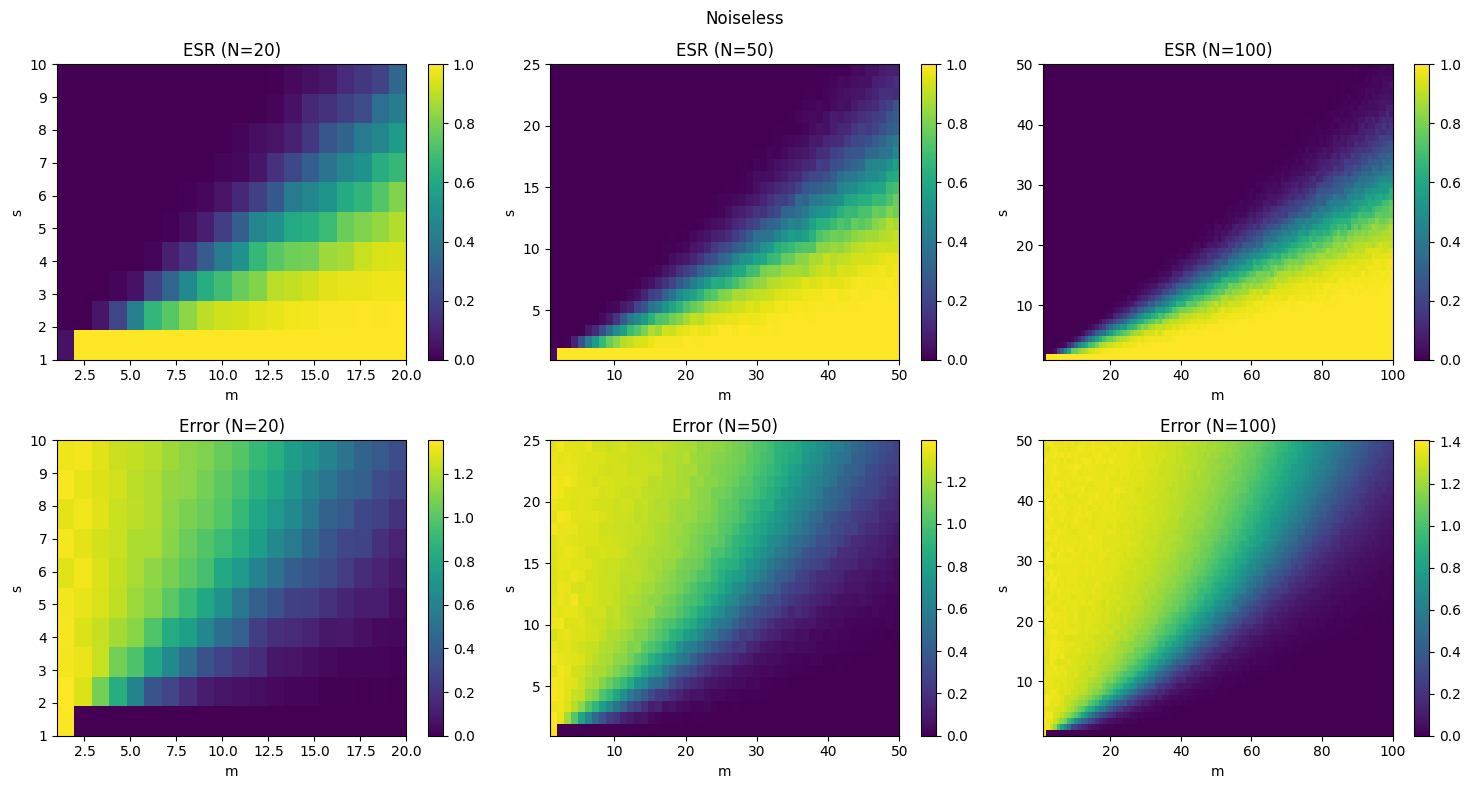

In [109]:
plotPhaseTransitions(N_list, resTest, "plots/noiseless", noise=False)

# Noisy case: (n  $\neq$ 0) - Sparsity Known

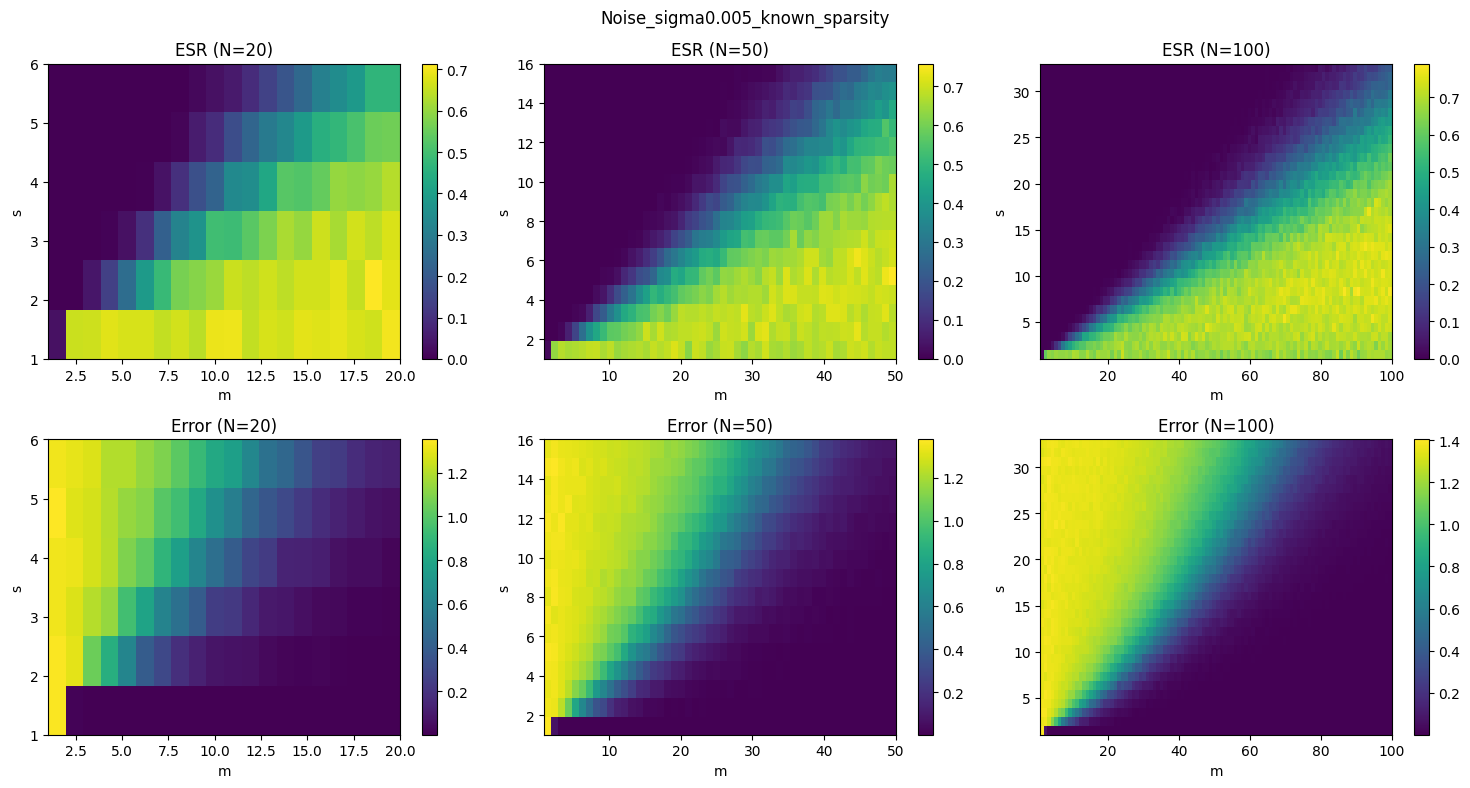

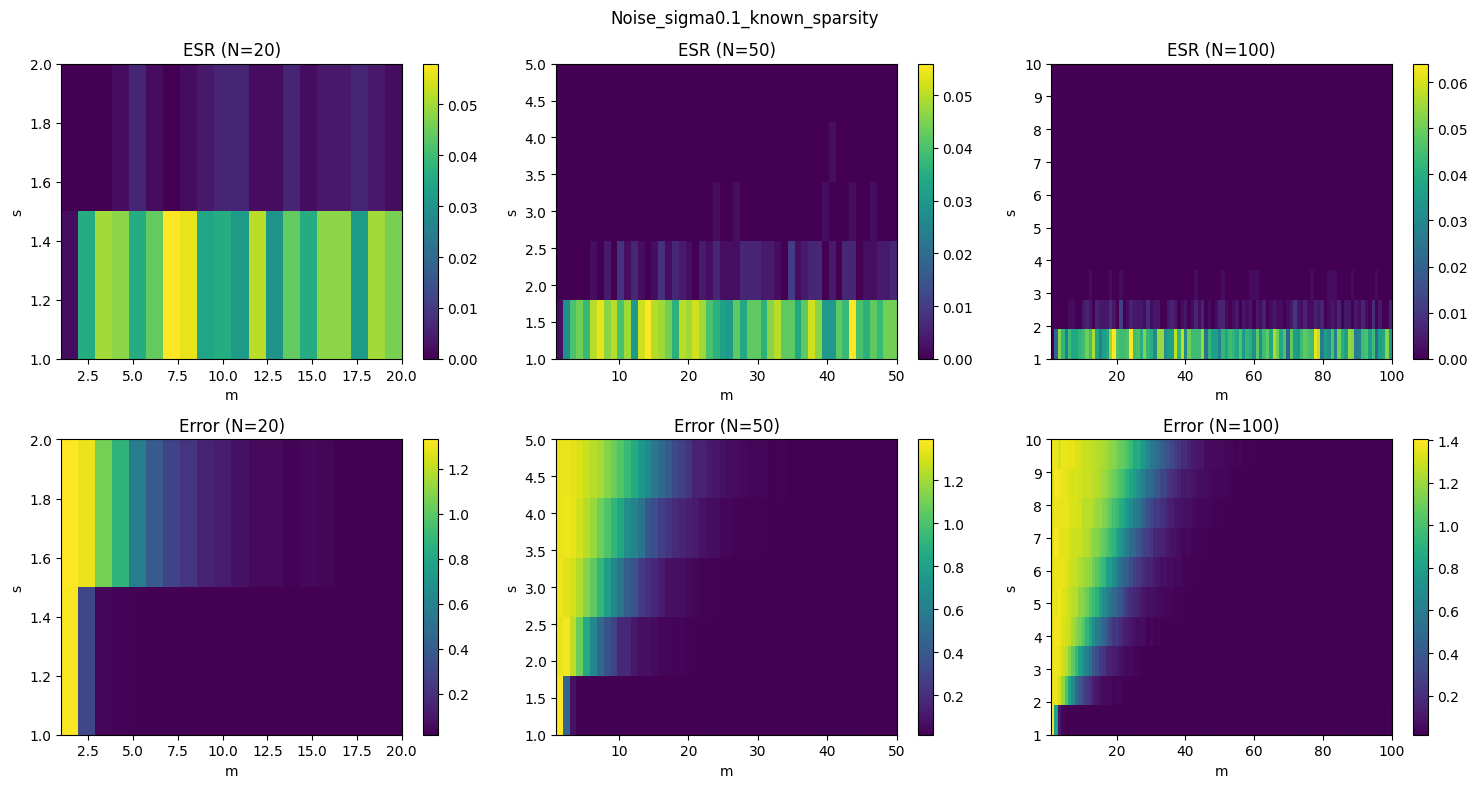

In [110]:
# Noise with Known Sparsity, sigma = 0.005
res2 = runAllPhaseTransitions(N_list, s_max = 3, noise = True, sigma = 0.005, s_known = True)
plotPhaseTransitions(N_list, res2, "plots/noise_known_small", noise = True, sigma = 0.005, s_known = True)

# Noise with Known Sparsity, sigma = 0.1
res3 = runAllPhaseTransitions(N_list, s_max = 10,  noise = True, sigma = 0.1, s_known = True)
plotPhaseTransitions(N_list, res3, "plots/noise_known_large", noise = True, sigma = 0.1, s_known = True)


# Noisy case: (n  $\neq$ 0) - Sparsity Unknown

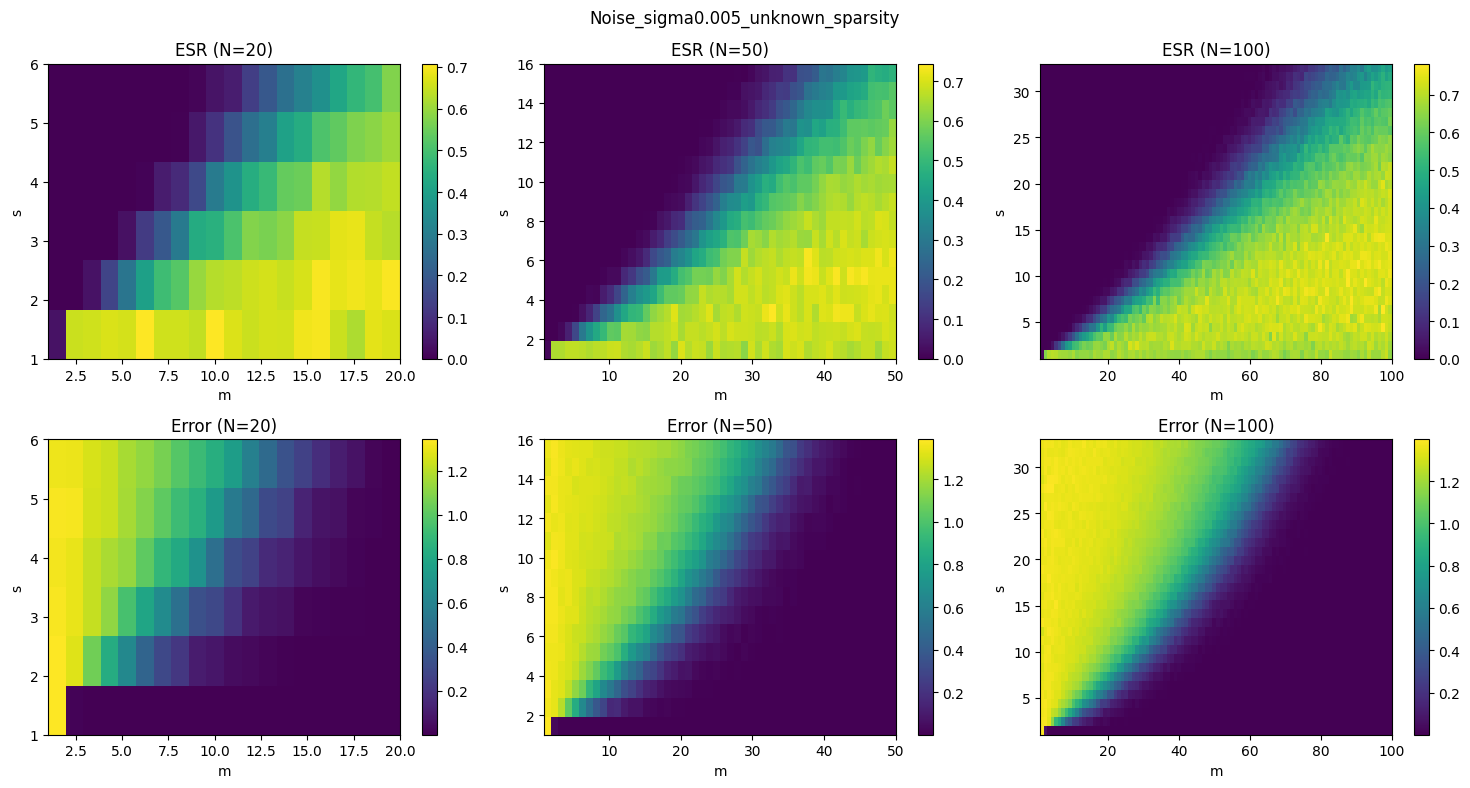

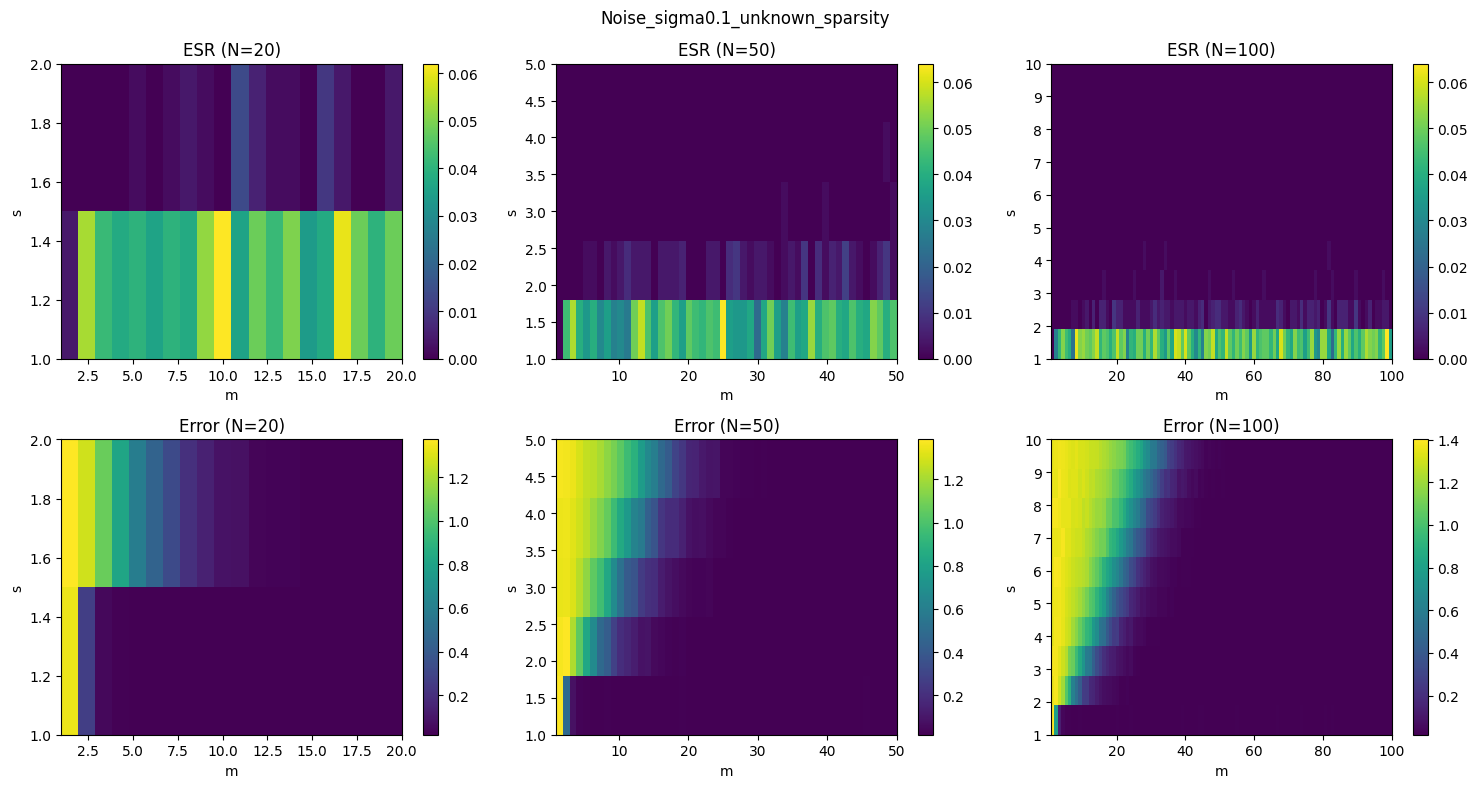

In [111]:

# Noise with Unknown Sparsity, sigma = 0.005
res4 = runAllPhaseTransitions(N_list, s_max = 3, noise = True, sigma = 0.005, s_known = False)
plotPhaseTransitions(N_list, res4, "plots/noise_unknown_small", noise=True, sigma=0.005, s_known=False)

# Noise with Unknown Sparsity, sigma = 0.1
res5 = runAllPhaseTransitions(N_list, s_max = 10, noise = True, sigma = 0.1, s_known = False)
plotPhaseTransitions(N_list, res5, "plots/noise_unknown_large", noise=True, sigma=0.1, s_known=False)





Discussion of Results:
We notice first of all that the Noisy case with unkown sparsity takes dramatically longer to stop since we don't have a sparsity we are aiming for. This expands the search much greater because while the OMP is trying to find the atom of best fit, it is going to struggle knowing when to stop since it can test for as many measurements as it has. 